# Pacchetto A — “Trend & differenze regionali” (4 grafici)

1. Linea con banda (mediana + IQR) per regione OMS, 2000–2022
    - Che mostra: come cambia la prevalenza adulta (tobacco smoking, both sexes, age-standardized) per regione.
    - Come: una linea per regione (mediana dei paesi) + banda IQR; annotazioni su “punti di svolta”.
    - Perché: vista pulita dei trend macro, consigliata dai paper (annotated line + uncertainty/range).

2. Slopegraph “2000 → 2022” per paesi selezionati (top popolazione) in ogni regione
    - Che mostra: variazione assoluta in p.p. per 8–10 paesi “rappresentativi” per regione.
    - Come: piccoli multipli per regione; ogni paese è una linea 2000→2022.
    - Perché: enfatizza chi scende di più e chi arretra (outlier: callout).

3. Mappa del mondo: variazione 2000→2022 di adult tobacco smoking, age-standardized, both sexes
    - Che mostra: “chi è migliorato quanto” in modo immediato, evitando sovrapposizioni col grafico 1 (livelli) e 2 (variazioni per pochi paesi).
    - Come: Metrica: Δ p.p. = (2022 osservato – 2000 osservato) dell’indicatore tobacco smoking, age-standardized, both sexes.
    - Perché: molto leggibile (paper su partitioned poster/small multiples).

4. Adolescenti vs Adulti (ultimo quinquennio disponibile per paese)
    - Che mostra: gap adolescenti (current smoking, Both) vs adulti (age-std, Both) per regione.
    - Come: dumbbell plot per paese (o boxplot per regione) usando l’ultimo anno 2017–2022 per adolescenti e 2022 per adulti.
    - Perché: collega il “serbatoio futuro” (GYTS) al livello adulto.

## 1. Linea con banda (mediana + IQR) per regione OMS, 2000–2022


Questo grafico rappresenta una sintesi dell’andamento del fumo di tabacco negli adulti (età ≥15 anni), stimato e corretto per età (age-standardized), considerando entrambi i sessi insieme.

Ecco come leggerlo:

Linee colorate → ognuna rappresenta una regione OMS (Africa, Americhe, Europa, ecc.).

Valore centrale (linea) → la mediana della prevalenza (%) del fumo di tabacco tra i Paesi della regione in un certo anno.

Bande trasparenti → l’intervallo interquartile (IQR), cioè l’area che contiene il 50% “centrale” dei Paesi della regione. Ti dice la variabilità interna: se la banda è larga, i Paesi sono molto diversi tra loro; se è stretta, sono simili.

Asse X (Anno) → copre l’intervallo 2000–2022 (ticks ogni 2 anni).

Asse Y (Prevalenza %) → percentuale della popolazione adulta che fuma tabacco.

# ADULTI

C:\Users\cola0\AppData\Local\Temp\ipykernel_18052\2982439301.py:120: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for reg, sub in agg.groupby("region_norm", sort=False):


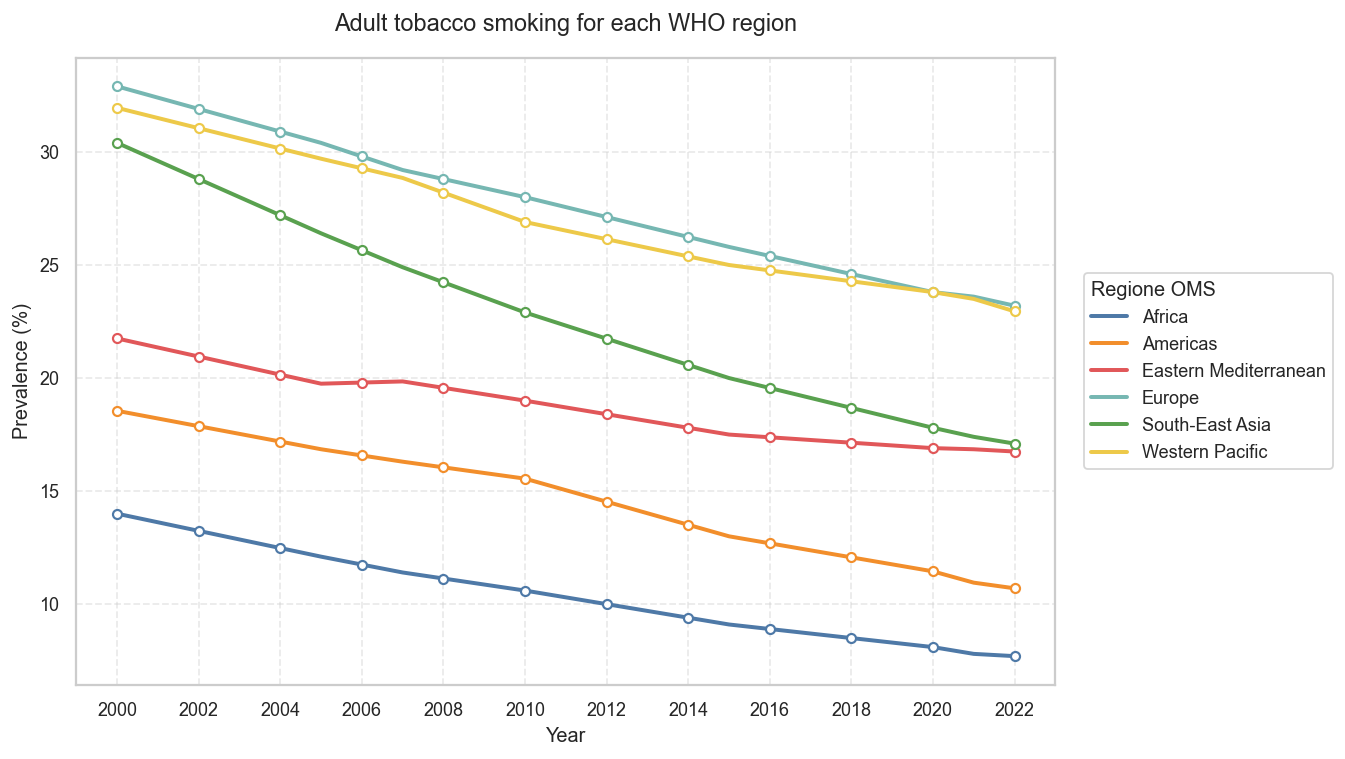

In [1]:
# === Grafico #1 (M): Adult tobacco smoking (age-standardized, Both) ===
# Mediana per regione OMS, 2000–2022 (NO IQR) + marker biennali

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # ok usare seaborn
from pathlib import Path
import glob
import re

# 1) Carica il file "age-standardized" dalla cartella M/
candidates = sorted(
    glob.glob("M/*age*standard*.*csv")
) or sorted(
    glob.glob("./M/*age*standard*.*csv")
)
if not candidates:
    raise FileNotFoundError("Non trovo il CSV age-standardized in ./M/.")
csv_path = candidates[0]
df = pd.read_csv(csv_path, encoding="utf-8-sig")

# 2) Mappa nomi colonna (robusto a varianti WHO)
cols = {c.lower(): c for c in df.columns}
def pick(*names):
    for n in names:
        if n.lower() in cols:
            return cols[n.lower()]
    raise KeyError(f"Manca una delle colonne richieste: {names}")

year_col    = pick("Period","TimeDim","Year")
region_col  = pick("ParentLocation","WHO region","Region")
sex_col     = cols.get("dim1") or cols.get("sex")
indicator_col = None
for cand in ["Indicator","IndicatorName","Indicator_Label","IndicatorLabel","GHO"]:
    if cand.lower() in cols:
        indicator_col = cols[cand.lower()]
        break
value_col = cols.get("factvaluenumeric") or cols.get("value")
if value_col is None:
    raise KeyError("Non trovo né FactValueNumeric né Value nel CSV.")

# 3) Filtro: indicatore = "tobacco smoking", sesso = Both, anni osservati
df_f = df.copy()
if indicator_col is not None and df_f[indicator_col].dtype == object:
    ind_norm = df_f[indicator_col].str.lower()
    mask = ind_norm.str.contains(r"tobacco\s*smoking", regex=True)
    if not mask.any():
        mask = ind_norm.str.contains(r"\bsmok", regex=True) & ~ind_norm.str.contains(r"cigarette|use", regex=True)
    df_f = df_f[mask] if mask.any() else df_f

if sex_col:
    df_f = df_f[df_f[sex_col].astype(str).str.contains(r"\bboth\b", flags=re.I, regex=True)]

df_f[value_col] = pd.to_numeric(df_f[value_col], errors="coerce")
df_f[year_col]  = pd.to_numeric(df_f[year_col], errors="coerce")
df_f = df_f[(df_f[year_col] >= 2000) & (df_f[year_col] <= 2022)]
df_f = df_f.dropna(subset=[value_col, year_col, region_col])

# 4) Aggregazione per regione: mediana (q1/q3 più non servono)
agg = (
    df_f.groupby([region_col, year_col], as_index=False)[value_col]
        .agg(mediana="median")
        .sort_values([region_col, year_col])
)

region_order = [
    "African Region", "Region of the Americas", "Eastern Mediterranean Region",
    "European Region", "South-East Asia Region", "Western Pacific Region"
]
short_map = {
    "African Region": "AFR","Region of the Americas": "AMR","Eastern Mediterranean Region": "EMR",
    "European Region": "EUR","South-East Asia Region": "SEAR","Western Pacific Region": "WPR",
}
# --- subito dopo aver definito region_order/short_map ---
# mappa alias -> nome WHO canonico
region_alias_to_who = {
    "Africa": "African Region",
    "Americas": "Region of the Americas",
    "Eastern Mediterranean": "Eastern Mediterranean Region",
    "Europe": "European Region",
    "South-East Asia": "South-East Asia Region",
    "Western Pacific": "Western Pacific Region",
}

agg["region_norm"] = agg[region_col].replace(region_alias_to_who)
agg["region_norm"] = agg["region_norm"].fillna(agg[region_col])  # se già in forma WHO

# ordina usando i nomi WHO
agg["region_norm"] = pd.Categorical(agg["region_norm"], categories=region_order, ordered=True)
agg = agg.sort_values(["region_norm", year_col])

if agg[region_col].isin(region_order).any():
    agg[region_col] = pd.Categorical(agg[region_col], categories=region_order, ordered=True)
    agg = agg.sort_values([region_col, year_col])

# 5) Plot (SOLO linee) + marker ogni due anni

new_palette = {
    "African Region": "#4E79A7",
    "Region of the Americas": "#F28E2B",
    "Eastern Mediterranean Region": "#E15759",
    "European Region": "#76B7B2",
    "South-East Asia Region": "#59A14F",
    "Western Pacific Region": "#EDC949",
}

# 5) Plot (linee + marker biennali con stile tipo grafico 2)

# 5) Plot (linee + marker ogni 2 anni tramite interpolazione)
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10.5, 6), dpi=130)

# anni biennali globali
min_year = int(agg[year_col].min())
max_year = int(agg[year_col].max())
start_even = min_year if (min_year % 2 == 0) else min_year + 1
biennial_years = np.arange(start_even, max_year + 1, 2)

for reg, sub in agg.groupby("region_norm", sort=False):
    if pd.isna(reg):
        continue

    x = sub[year_col].astype(int).to_numpy()
    y = sub["mediana"].to_numpy()

    # colore dalla palette (ora la chiave esiste sempre)
    line_color = new_palette.get(reg)

    # etichetta leggibile o acronimo: scegli tu
    label = short_map.get(reg, reg)  # "AFR", "AMR", ... altrimenti nome WHO
    # se vuoi le forme corte in legenda:
    pretty = {
        "African Region": "Africa",
        "Region of the Americas": "Americas",
        "Eastern Mediterranean Region": "Eastern Mediterranean",
        "European Region": "Europe",
        "South-East Asia Region": "South-East Asia",
        "Western Pacific Region": "Western Pacific",
    }
    label = pretty.get(reg, label)

    line, = ax.plot(x, y, label=label, color=line_color, linewidth=2.2, zorder=1)

    # marker biennali
    m = (biennial_years >= x.min()) & (biennial_years <= x.max())
    xm = biennial_years[m]
    ym = np.interp(xm, x, y)
    ax.plot(
        xm, ym, linestyle="None",
        marker="o", markersize=5.0,
        markerfacecolor="white",
        markeredgecolor=line_color, markeredgewidth=1.2, zorder=2
    )


# titoli/assi/griglia come nel 2° grafico
#ax.set_title("Adult tobacco smoking — age-standardized, Both (mediana per regione OMS)", fontsize=13, pad=15)
ax.set_title("Adult tobacco smoking for each WHO region", fontsize=13, pad=15)

ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Prevalence (%)", fontsize=11)
ax.grid(True, linestyle="--", alpha=0.4)
ax.tick_params(axis="both", labelsize=10)

# ticks biennali perfettamente allineati ai marker
ax.set_xlim(min_year-1, max_year+1)
ax.set_xticks(biennial_years)

# legenda a destra
plt.subplots_adjust(right=0.78)
leg = ax.legend(
    title="Regione OMS",
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    ncols=1, frameon=True, fontsize=10, title_fontsize=11
)
try:
    leg._legend_box.align = "left"
except Exception:
    pass

plt.tight_layout()
Path("M/outputs").mkdir(parents=True, exist_ok=True)
plt.savefig("M/outputs/monitor_trend_regione_mediana_NOIQR_markers.png", bbox_inches="tight")
plt.show()



NameError: name 'regions_present' is not defined

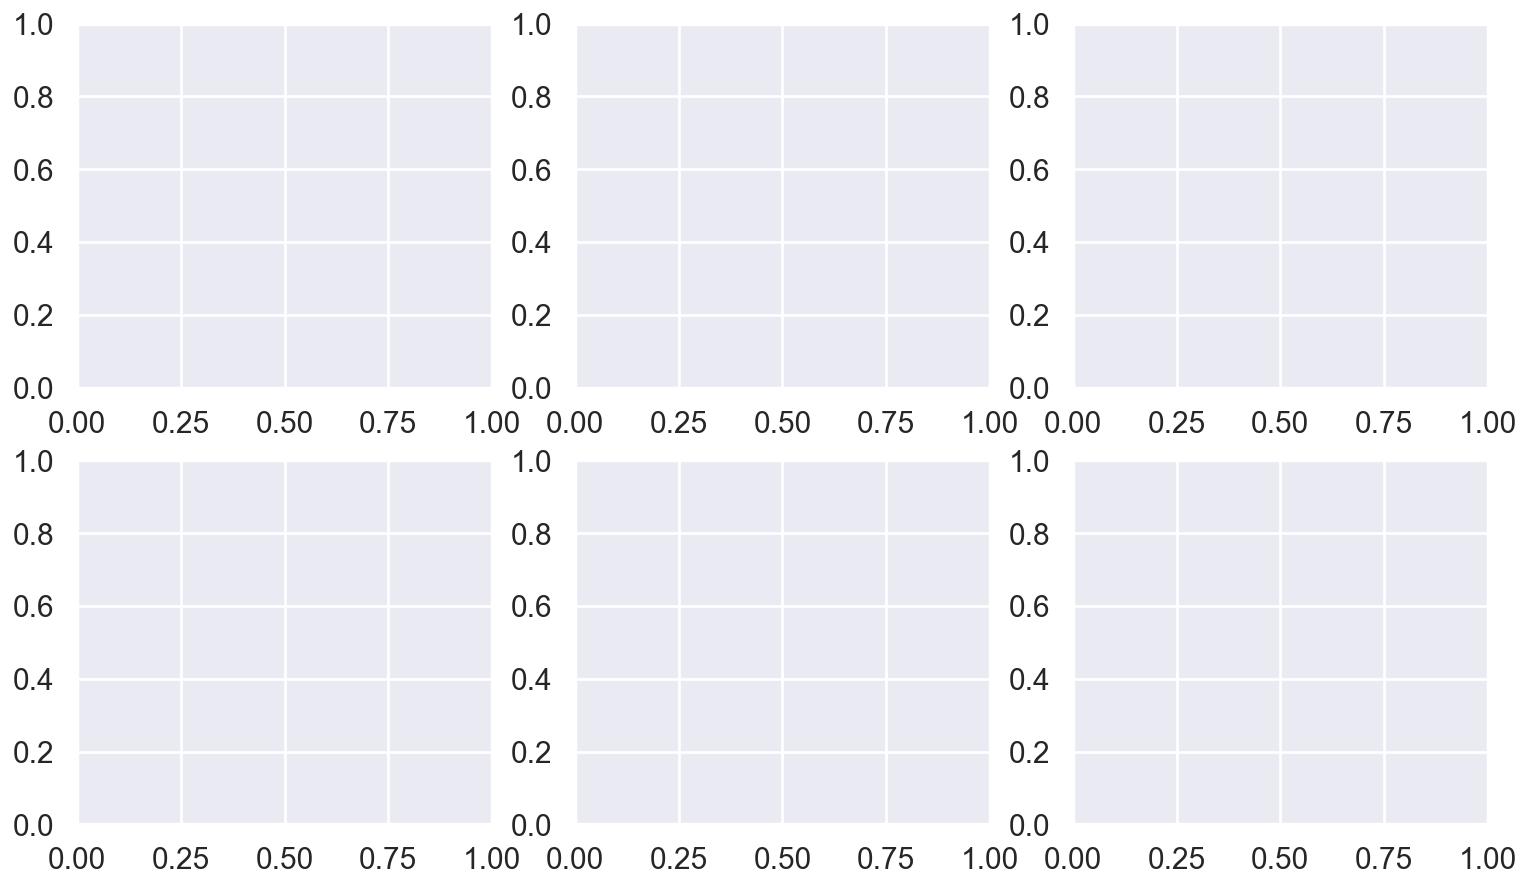

In [2]:
# ------------------ Plot: grouped bar charts 2000 vs 2022 per regione OMS ------------------
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns

sns.set_theme(context="talk")

# ---- parametri font ----
FONT_SUP   = 14
FONT_PANEL = 12
FONT_AXIS  = 11
FONT_TICK  = 9
LEG_FONTSZ = 9

SHORT = {
    "African Region": "Africa",
    "Region of the Americas": "Americas",
    "Eastern Mediterranean Region": "Eastern Mediterranean",
    "European Region": "Europe",
    "South-East Asia Region": "South-East Asia",
    "Western Pacific Region": "Western Pacific"
}


def adjust_color(hex_color, factor=1.0):
    """schiarisce (factor>1) o scurisce (factor<1) un colore hex."""
    c = np.array(mcolors.to_rgb(hex_color))
    if factor > 1:  # blend verso bianco
        return mcolors.to_hex(c + (1 - c) * (factor - 1))
    else:           # blend verso nero
        return mcolors.to_hex(c * factor)

# griglia fissa 2 righe × 3 colonne
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 8), dpi=130)
axes = np.atleast_1d(axes).ravel()

for i, reg in enumerate(regions_present):
    ax = axes[i]
    sub = sel[sel[region_col] == reg]
    if sub.empty:
        ax.axis("off")
        continue

    sub_ord = sub.sort_values("y_start", ascending=False).reset_index(drop=True)
    countries = sub_ord[loc_col].tolist()
    x = np.arange(len(countries))
    width = 0.36

    base_color = PALETTE_REGION.get(reg, "tab:gray")
    color_2000 = adjust_color(base_color, 1.4)  # più chiaro
    color_2022 = adjust_color(base_color, 0.8)  # più scuro

    y0 = sub_ord["y_start"].to_numpy(dtype=float)
    y1 = sub_ord["y_end"].to_numpy(dtype=float)

    y_min = float(min(y0.min(), y1.min())) - 1.0
    y_max = float(max(y0.max(), y1.max())) + 1.0

    # Barre affiancate
    ax.bar(x - width/2, y0, width=width, color=color_2000, edgecolor="black", linewidth=0.3, label="2000")
    ax.bar(x + width/2, y1, width=width, color=color_2022, edgecolor="black", linewidth=0.3, label="2022")

    # Assi, titoli, griglia
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(x)
    ax.set_xticklabels(countries, fontsize=FONT_TICK, rotation=25, ha="right")
    ax.tick_params(axis="y", labelsize=FONT_TICK)
    ax.set_title(f"{SHORT.get(reg, reg)}", fontsize=FONT_PANEL, pad=6)
    ax.grid(True, axis="y", alpha=0.25)

    # etichetta asse Y per ogni subplot
    ax.set_ylabel("Prevalence (%)", fontsize=FONT_AXIS, labelpad=6)

    # Legenda (solo anni)
    year_handles = [
        Patch(facecolor=color_2000, edgecolor="black", label="2000"),
        Patch(facecolor=color_2022, edgecolor="black", label="2022"),
    ]
    ax.legend(handles=year_handles, loc="upper right", fontsize=LEG_FONTSZ, frameon=True)

# spegni eventuali subplot vuoti
for j in range(i + 1, n_rows * n_cols):
    axes[j].axis("off")

fig.suptitle("Adult tobacco smoking - Top 4 countries for each WHO region",
             fontsize=FONT_SUP, y=0.90)

plt.tight_layout(rect=[0.04, 0.04, 0.98, 0.95])
Path("M/outputs").mkdir(parents=True, exist_ok=True)
plt.savefig("M/outputs/monitor_bars_regioni_2000_2022.png", bbox_inches="tight")
plt.show()


📊 Primo grafico (linee mediane per regione OMS)
-   Mostra l’andamento medio della prevalenza del fumo negli adulti (2000–2022) per ciascuna regione OMS (Africa, Europa, Americhe, ecc.).

- È una visione macroscopica e aggregata: ogni regione è rappresentata da una curva unica (mediana + intervallo interquartile).

- Risponde alla domanda: “A livello di grandi aree del mondo, come si è evoluta la prevalenza del fumo negli adulti?”


📈 Secondo grafico (slopegraph a gradazioni per Paesi selezionati)

- Qui scendiamo di dettaglio: per ogni regione OMS mostriamo alcuni Paesi (i 5 con serie storiche più complete, o quelli col calo maggiore).

- Ogni linea collega il valore di prevalenza ≈2000 con quello ≈2022.

- Le gradazioni di colore distinguono i Paesi dentro la stessa regione (con legenda dedicata).

- Risponde alla domanda: “Dentro ogni regione, quali Paesi hanno ridotto di più il fumo? Quali invece restano più alti?”


🔗 Relazione tra i due grafici

- Il primo dà la fotografia di insieme per macro-aree.

- Il secondo “apre la scatola” e mostra la variabilità interna alle regioni: capiamo se il trend regionale è trainato da alcuni Paesi, o se è condiviso da tutti.

- 💡 In sintesi: il primo è la vista globale comparativa tra regioni, il secondo è la vista dettagliata dentro le regioni, complementari tra loro.


In [ ]:
%pip install -U geodatasets


Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install -U plotly kaleido

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# === Grafico #3 (M), versione Plotly: Mappa Δ (ultimo≤2022 − primo≥2000)
# Adult tobacco smoking — age-standardized, Both sexes (WHO)
import pandas as pd, numpy as np, glob, re
import plotly.express as px
from pathlib import Path

# (se serve, installa direttamente nel notebook)
# %pip install -U plotly kaleido

# ------------------ 1) Carica e filtra dati WHO ------------------
candidates = sorted(glob.glob("M/*age*standard*.*csv")) or sorted(glob.glob("./M/*age*standard*.*csv"))
if not candidates:
    raise FileNotFoundError("Non trovo il CSV age-standardized in ./M/")
df = pd.read_csv(candidates[0], encoding="utf-8-sig")

cols = {c.lower(): c for c in df.columns}
def pick(*names):
    for n in names:
        if n.lower() in cols: 
            return cols[n.lower()]
    raise KeyError(f"Manca una delle colonne richieste: {names}")

year_col = pick("Period","TimeDim","Year")
iso_col  = pick("SpatialDimValueCode","ISO3","ISO")
loc_col  = pick("Location","Country","SpatialDim")
sex_col  = cols.get("dim1") or cols.get("sex")
val_col  = cols.get("factvaluenumeric") or cols.get("value")
ind_col  = next((cols[k] for k in ["indicator","indicatorname","indicator_label","indicatorlabel","gho"] if k in cols), None)

df_f = df.copy()
if ind_col is not None and df_f[ind_col].dtype == object:
    m = df_f[ind_col].str.lower().str.contains(r"tobacco\s*smoking", regex=True)
    if m.any(): 
        df_f = df_f[m]

if sex_col:
    df_f = df_f[df_f[sex_col].astype(str).str.contains(r"\bboth\b", flags=re.I, regex=True)]

df_f[val_col]  = pd.to_numeric(df_f[val_col], errors="coerce")
df_f[year_col] = pd.to_numeric(df_f[year_col], errors="coerce")
df_f = df_f[(df_f[year_col] >= 2000) & (df_f[year_col] <= 2022)]
df_f = df_f.dropna(subset=[val_col, year_col, iso_col])

# ------------------ 2) Primo/ultimo anno per Paese + Δ (p.p.) ------------------
df_g = (df_f[[iso_col, loc_col, year_col, val_col]]
        .sort_values([iso_col, year_col])
        .drop_duplicates(subset=[iso_col, year_col], keep="last"))

summ = (df_g.groupby([iso_col, loc_col], as_index=False)
          .agg(year_start=(year_col, "first"),
               year_end=(year_col, "last"),
               y_start=(val_col, "first"),
               y_end=(val_col, "last")))
summ["delta_pp"] = summ["y_end"] - summ["y_start"]

approx_mask = (summ["year_start"] != 2000) | (summ["year_end"] != 2022)
n_approx = int(approx_mask.sum())

# ------------------ 3) Choropleth Plotly (scala divergente simmetrica) ------------------
# Range simmetrico robusto sui percentili (evita outlier estremi)
lo, hi = np.nanpercentile(summ["delta_pp"], [2, 98])
m = float(max(abs(lo), abs(hi))) if np.isfinite(lo) and np.isfinite(hi) else float(np.nanmax(np.abs(summ["delta_pp"])))

fig = px.choropleth(
    summ,
    locations=iso_col,                    # ISO3
    color="delta_pp",
    color_continuous_scale="RdBu_r",      # blu = calo, rosso = aumento
    range_color=[-m, m],
    hover_name=loc_col,
    hover_data={
        "delta_pp":":+.1f",
        "y_start":":.1f", "y_end":":.1f",
        "year_start": True, "year_end": True,
        iso_col: False
    },
    projection="natural earth",
    title="Adult tobacco smoking: % variation from 2000s to 2022 for each country",
)

fig.update_geos(
    showcountries=True,        # mostra i confini dei paesi
    showcoastlines=False,      # niente linee costiere
    showframe=False,           # niente cornice
    landcolor="rgb(240,240,240)"
)
fig.update_geos(
    showcountries=True,
    showcoastlines=False,
    showframe=False,
    landcolor="rgb(240,240,240)"
)

fig.update_layout(
    margin=dict(l=0, r=0, t=70, b=0),
    coloraxis_colorbar=dict(
        title=dict(text="Δ (p.p.)", font=dict(size=11)),
        tickfont=dict(size=10),
        thickness=12,
        len=0.8
    ),
    font=dict(size=12)
)


fig.show()


fig.show()

# ------------------ 4) (Opzionale) salva PNG ------------------
try:
    import plotly.io as pio
    Path("M/outputs").mkdir(parents=True, exist_ok=True)
    pio.write_image(fig, "M/outputs/monitor_worldmap_delta_2000_2022.png", scale=3, width=1200, height=650)
except Exception:
    print("Per salvare PNG installa 'kaleido' nel kernel del notebook:  %pip install -U kaleido")


La mappa coropletica mostra, per ciascun Paese, la variazione della prevalenza di fumatori adulti (age-standardized, entrambi i sessi) tra il primo anno disponibile ≥2000 e l’ultimo ≤2022.

- Colori blu = diminuzione della prevalenza (in punti percentuali).

- Colori rossi = aumento della prevalenza.

- L’intensità indica la magnitudine: più scuro = cambiamento più forte.

In pratica, è una fotografia globale delle differenze nel trend ventennale, condensata in un unico valore per Paese.

Cosa ci permette di capire

- Geografia delle riduzioni: molti Paesi in Europa, Americhe e parte dell’Asia hanno registrato forti cali (blu scuro).

- Eccezioni locali: alcuni Paesi hanno registrato aumenti o cali minimi (toni rossastri o grigio chiaro).

- Omogeneità vs disomogeneità: non tutte le regioni sono uniformi; per esempio, in Africa il declino è meno marcato e più eterogeneo.


Relazione con gli altri due grafici

- Grafico 1 (trend per regioni OMS): mostra la tendenza media regionale nel tempo (2000–2022). Ti dà il quadro aggregato.

- Grafico 2 (slopegraph per 5 Paesi/regione): mette in evidenza la variabilità all’interno delle regioni e i Paesi con serie più complete.

- Grafico 3 (mappa mondiale): estende l’analisi a tutti i Paesi mostrando dove i cali sono stati più marcati o dove ci sono state anomalie.

Insieme i tre grafici ti permettono di:

- passare da un overview globale (mappa),

- a una visione regionale (grafico 1),

- fino a uno zoom su Paesi specifici (grafico 2).

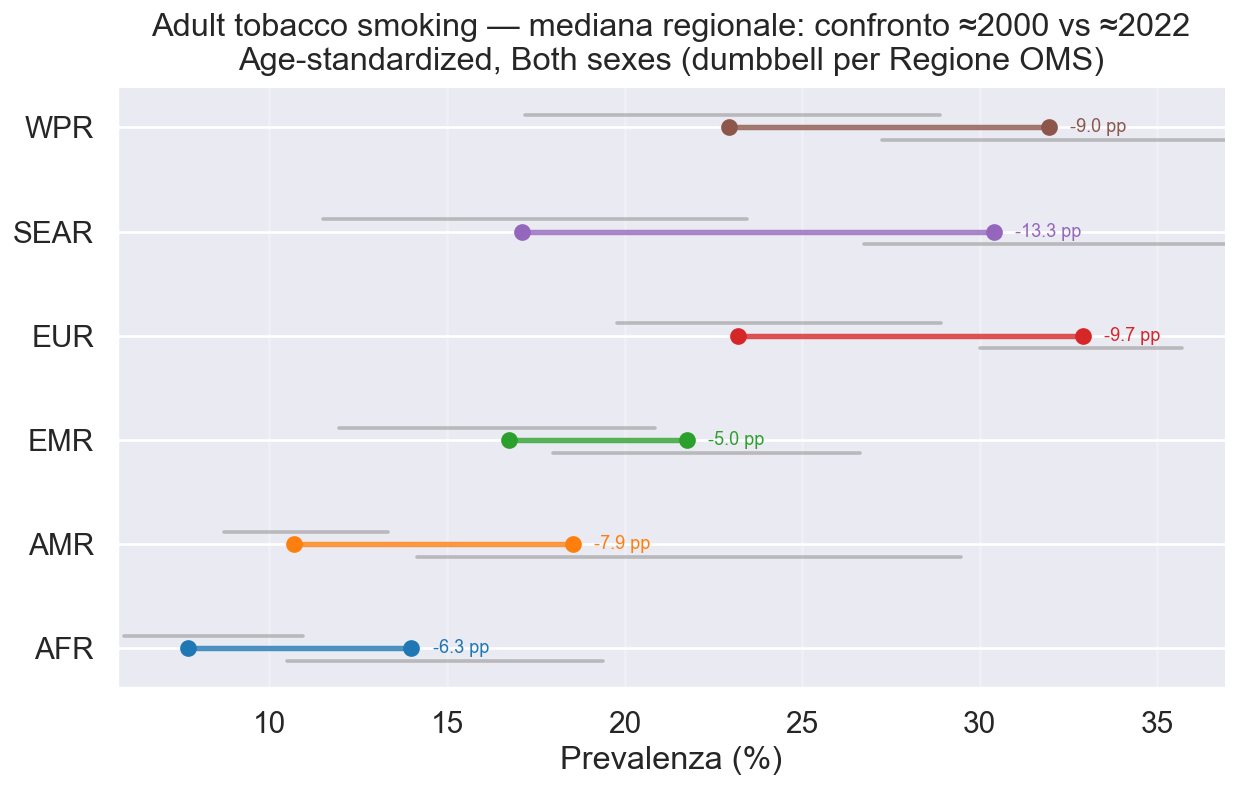

In [ ]:
# === Grafico #4 (M): Dumbbell 2000→2022 (mediana per Regione OMS) ===
import pandas as pd, numpy as np, glob, re
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ---------------- Parametri/Palette ----------------
PALETTE_REGION = {
    "African Region": "#1f77b4",          # blu
    "Region of the Americas": "#ff7f0e",  # arancione
    "Eastern Mediterranean Region": "#2ca02c",
    "European Region": "#d62728",
    "South-East Asia Region": "#9467bd",
    "Western Pacific Region": "#8c564b",
}
REGION_ORDER = [
    "African Region", "Region of the Americas", "Eastern Mediterranean Region",
    "European Region", "South-East Asia Region", "Western Pacific Region"
]
SHORT = {"African Region":"AFR","Region of the Americas":"AMR","Eastern Mediterranean Region":"EMR",
         "European Region":"EUR","South-East Asia Region":"SEAR","Western Pacific Region":"WPR"}

# ---------------- Carica & filtra (stesso file dei grafici precedenti) ----------------
candidates = sorted(glob.glob("M/*age*standard*.*csv")) or sorted(glob.glob("./M/*age*standard*.*csv"))
if not candidates:
    raise FileNotFoundError("Non trovo il CSV age-standardized in ./M/")
df = pd.read_csv(candidates[0], encoding="utf-8-sig")

cols = {c.lower(): c for c in df.columns}
def pick(*names):
    for n in names:
        if n.lower() in cols: return cols[n.lower()]
    raise KeyError(f"Manca una delle colonne richieste: {names}")

year_col   = pick("Period","TimeDim","Year")
region_col = pick("ParentLocation","WHO region","Region")
loc_col    = pick("Location","Country","SpatialDim")
iso_col    = pick("SpatialDimValueCode","ISO3","ISO")
sex_col    = cols.get("dim1") or cols.get("sex")
val_col    = cols.get("factvaluenumeric") or cols.get("value")
ind_col    = next((cols[k] for k in ["indicator","indicatorname","indicator_label","indicatorlabel","gho"] if k in cols), None)

df_f = df.copy()
# indicatore adult tobacco smoking
if ind_col is not None and df_f[ind_col].dtype == object:
    m = df_f[ind_col].str.lower().str.contains(r"tobacco\s*smoking", regex=True)
    if m.any(): df_f = df_f[m]
# both sexes
if sex_col:
    df_f = df_f[df_f[sex_col].astype(str).str.contains(r"\bboth\b", flags=re.I, regex=True)]

# normalizza tipi e anni
df_f[val_col]  = pd.to_numeric(df_f[val_col], errors="coerce")
df_f[year_col] = pd.to_numeric(df_f[year_col], errors="coerce")
df_f = df_f[(df_f[year_col] >= 2000) & (df_f[year_col] <= 2022)]
df_f = df_f.dropna(subset=[val_col, year_col, region_col, iso_col, loc_col])

# uniforma nomi regioni (alias comuni)
region_alias = {
    "AFR":"African Region","Africa":"African Region",
    "AMR":"Region of the Americas","Americas":"Region of the Americas",
    "EMR":"Eastern Mediterranean Region","Eastern Mediterranean":"Eastern Mediterranean Region",
    "EUR":"European Region","EURO":"European Region","Europe":"European Region",
    "SEAR":"South-East Asia Region","South-East Asia":"South-East Asia Region",
    "WPR":"Western Pacific Region","Western Pacific":"Western Pacific Region",
}
df_f[region_col] = df_f[region_col].astype(str).str.strip().replace(region_alias)

# ---------------- Costruisci start/end per ogni Paese (primo >=2000, ultimo <=2022) ----------------
df_g = (df_f[[region_col, iso_col, loc_col, year_col, val_col]]
        .sort_values([region_col, iso_col, year_col])
        .drop_duplicates(subset=[iso_col, year_col], keep="last"))

per_country = (df_g.groupby([region_col, iso_col, loc_col], as_index=False)
                 .agg(year_start=(year_col, "first"),
                      year_end=(year_col, "last"),
                      y_start=(val_col, "first"),
                      y_end=(val_col, "last")))

# tieni solo paesi con entrambi gli estremi
per_country = per_country.dropna(subset=["y_start","y_end"])

# ---------------- Aggrega per Regione: mediana (e IQR opzionali) ----------------
agg = (per_country.groupby(region_col, as_index=False)
         .agg(
             start_med=("y_start","median"),
             end_med=("y_end","median"),
             start_q1=("y_start", lambda s: np.percentile(s,25)),
             start_q3=("y_start", lambda s: np.percentile(s,75)),
             end_q1=("y_end", lambda s: np.percentile(s,25)),
             end_q3=("y_end", lambda s: np.percentile(s,75)),
             n_countries=("y_start","count")
         ))

agg["delta_pp"] = agg["end_med"] - agg["start_med"]
# ordina per l'ordine canonico OMS
agg["region_order"] = agg[region_col].apply(lambda r: REGION_ORDER.index(r) if r in REGION_ORDER else 99)
agg = agg.sort_values("region_order")

# ---------------- Plot dumbbell ----------------
sns.set_theme(context="talk")
fig, ax = plt.subplots(figsize=(11, 6), dpi=130)

y_pos = np.arange(len(agg))
# linee connettori
for i, r in enumerate(agg.itertuples(index=False)):
    color = PALETTE_REGION.get(getattr(r, region_col), "tab:gray")
    ax.plot([r.start_med, r.end_med], [i, i], color=color, lw=3, alpha=0.8, solid_capstyle="round")
    ax.scatter([r.start_med, r.end_med], [i, i], color=color, s=60, zorder=3)
    # etichetta Δ
    ax.text(max(r.start_med, r.end_med)+0.6, i, f"{r.delta_pp:+.1f} pp",
            va="center", ha="left", fontsize=10, color=color)

# opzionale: “barrette” per IQR agli estremi (commenta se non vuoi)
for i, r in enumerate(agg.itertuples(index=False)):
    color = "#999999"
    ax.plot([r.start_q1, r.start_q3], [i-0.12, i-0.12], color=color, lw=2, alpha=0.6)
    ax.plot([r.end_q1, r.end_q3], [i+0.12, i+0.12], color=color, lw=2, alpha=0.6)

# aspetto assi
ax.set_yticks(y_pos, [SHORT.get(reg, reg) for reg in agg[region_col]])
ax.set_xlabel("Prevalenza (%)")
ax.set_title("Adult tobacco smoking — mediana regionale: confronto ≈2000 vs ≈2022\nAge-standardized, Both sexes (dumbbell per Regione OMS)", pad=10)

# limiti x con margine
xmin = float(min(agg[["start_med","end_med"]].min())) - 2
xmax = float(max(agg[["start_med","end_med"]].max())) + 4
ax.set_xlim(max(0, xmin), xmax)

ax.grid(True, axis="x", alpha=0.25)
ax.spines[["top","right"]].set_visible(False)

# nota su campione usato
tot = int(per_country.groupby(region_col).size().sum())
#fig.text(0.01, 0.01, "Ogni punto = mediana tra paesi della regione.\nBarrette sottili: IQR delle distribuzioni regionali ai due estremi.\n",fontsize=9)

Path("M/outputs").mkdir(parents=True, exist_ok=True)
plt.savefig("M/outputs/monitor_dumbbell_regioni_2000_2022.png", bbox_inches="tight")
plt.show()


Per ogni regione OMS hai due punti:

- sinistra = mediana della prevalenza adulti ≈2000 (primo anno ≥2000 disponibile nei Paesi della regione);

- destra = mediana ≈2022 (ultimo anno ≤2022 disponibile).

- La linea collega i due punti ⇒ direzione e entità del cambiamento.

- Il numerino a destra è il Δ in punti percentuali (2022 − 2000): negativo = calo (buono).

Perché è utile

- Confronti il livello (quanto fumava mediamente la regione) e il progresso (quanto è scesa).

- Ti fa vedere chi partiva più alto/basso e chi è migliorato di più.

- Completa gli altri grafici: dopo trend globali, dettaglio Paesi e mappa, qui hai il riassunto per regione in due istanti temporali.

Le barre grigie (IQR)

- Sono l’InterQuartile Range (25°–75° percentile) delle distribuzioni tra Paesi della regione in quel punto nel tempo:

- barra in basso (vicino al punto di sinistra) → variabilità interna della regione ~2000;

- barra in alto (vicino al punto di destra) → variabilità ~2022.

- Lunghe = grande eterogeneità tra Paesi; corte = regioni più omogenee.

- Se l’IQR si restringe dal 2000 al 2022 ⇒ i Paesi della regione stanno convergendo; se si allarga ⇒ maggiore disomogeneità.

C:\Users\cola0\AppData\Local\Temp\ipykernel_23228\2593797106.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\cola0\AppData\Local\Temp\ipykernel_23228\2593797106.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\cola0\AppData\Local\Temp\ipykernel_23228\2593797106.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_short, rotation=0, ha="center")


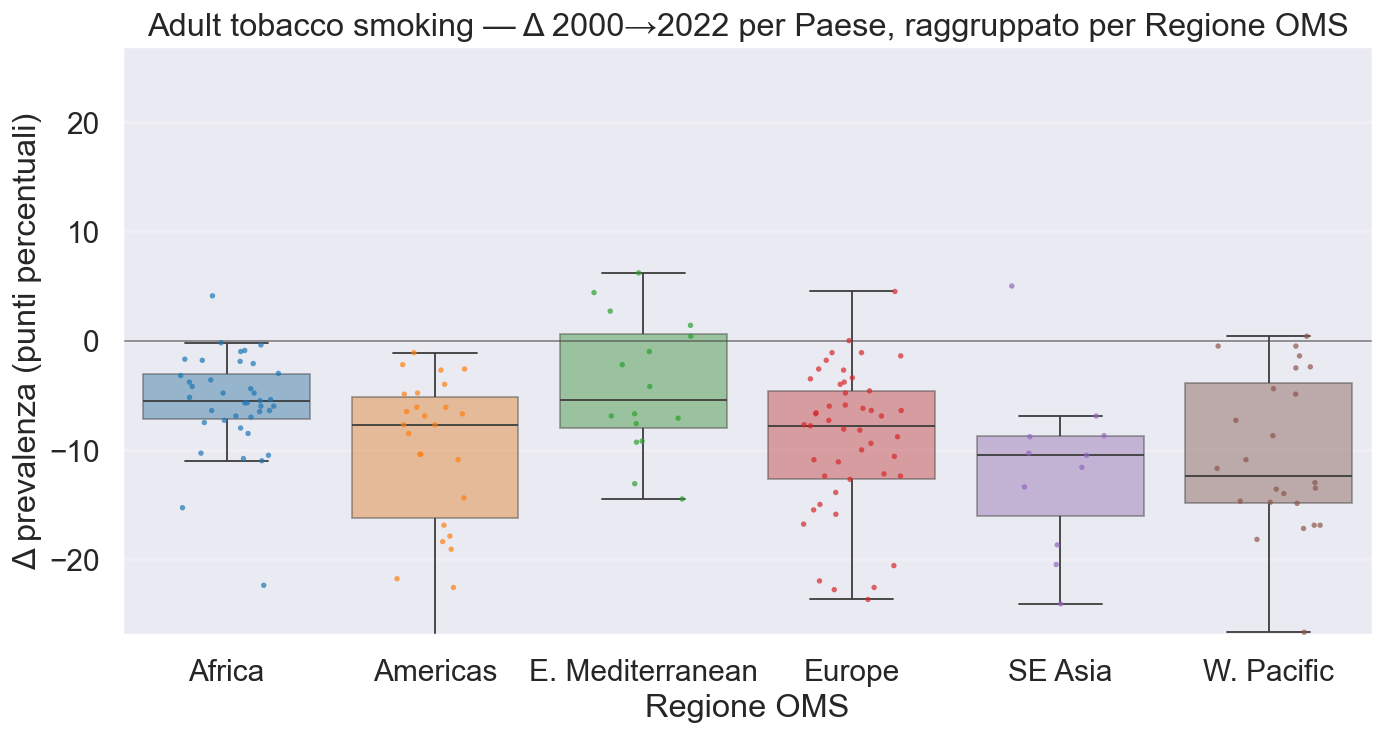

In [ ]:
# === Grafico #4 (alternativo, M): Δ per Paese (ultimo≤2022 − primo≥2000) per Regione OMS
import pandas as pd, numpy as np, glob, re
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Palette & ordine coerenti
PALETTE_REGION = {
    "African Region": "#1f77b4",
    "Region of the Americas": "#ff7f0e",
    "Eastern Mediterranean Region": "#2ca02c",
    "European Region": "#d62728",
    "South-East Asia Region": "#9467bd",
    "Western Pacific Region": "#8c564b",
}
REGION_ORDER = [
    "African Region", "Region of the Americas", "Eastern Mediterranean Region",
    "European Region", "South-East Asia Region", "Western Pacific Region"
]

# -------- Carica e filtra (stesso CSV usato prima) --------
candidates = sorted(glob.glob("M/*age*standard*.*csv")) or sorted(glob.glob("./M/*age*standard*.*csv"))
if not candidates:
    raise FileNotFoundError("Non trovo il CSV age-standardized in ./M/")
df = pd.read_csv(candidates[0], encoding="utf-8-sig")

cols = {c.lower(): c for c in df.columns}
def pick(*names):
    for n in names:
        if n.lower() in cols: return cols[n.lower()]
    raise KeyError(f"Manca una delle colonne richieste: {names}")

year_col   = pick("Period","TimeDim","Year")
region_col = pick("ParentLocation","WHO region","Region")
loc_col    = pick("Location","Country","SpatialDim")
iso_col    = pick("SpatialDimValueCode","ISO3","ISO")
sex_col    = cols.get("dim1") or cols.get("sex")
val_col    = cols.get("factvaluenumeric") or cols.get("value")
ind_col    = next((cols[k] for k in ["indicator","indicatorname","indicator_label","indicatorlabel","gho"] if k in cols), None)

df_f = df.copy()
if ind_col is not None and df_f[ind_col].dtype == object:
    m = df_f[ind_col].str.lower().str.contains(r"tobacco\s*smoking", regex=True)
    if m.any(): df_f = df_f[m]
if sex_col:
    df_f = df_f[df_f[sex_col].astype(str).str.contains(r"\bboth\b", flags=re.I, regex=True)]

df_f[val_col]  = pd.to_numeric(df_f[val_col], errors="coerce")
df_f[year_col] = pd.to_numeric(df_f[year_col], errors="coerce")
df_f = df_f[(df_f[year_col] >= 2000) & (df_f[year_col] <= 2022)]
df_f = df_f.dropna(subset=[val_col, year_col, region_col, iso_col, loc_col])

# uniforma eventuali alias di regione
region_alias = {
    "AFR":"African Region","Africa":"African Region",
    "AMR":"Region of the Americas","Americas":"Region of the Americas",
    "EMR":"Eastern Mediterranean Region","Eastern Mediterranean":"Eastern Mediterranean Region",
    "EUR":"European Region","EURO":"European Region","Europe":"European Region",
    "SEAR":"South-East Asia Region","South-East Asia":"South-East Asia Region",
    "WPR":"Western Pacific Region","Western Pacific":"Western Pacific Region",
}
df_f[region_col] = df_f[region_col].astype(str).str.strip().replace(region_alias)

# -------- Primo/ultimo per Paese e Δ --------
g = (df_f[[region_col, iso_col, loc_col, year_col, val_col]]
     .sort_values([iso_col, year_col])
     .drop_duplicates(subset=[iso_col, year_col], keep="last"))

per_country = (g.groupby([region_col, iso_col, loc_col], as_index=False)
                 .agg(year_start=(year_col, "first"),
                      year_end=(year_col, "last"),
                      y_start=(val_col, "first"),
                      y_end=(val_col, "last")))
per_country = per_country.dropna(subset=["y_start","y_end"])
per_country["delta_pp"] = per_country["y_end"] - per_country["y_start"]

# y-range simmetrico sui percentili (robusto agli outlier)
lo, hi = np.nanpercentile(per_country["delta_pp"], [2, 98])
m = float(max(abs(lo), abs(hi)))
ymin, ymax = -m-1, m+1

# -------- Plot: boxplot + swarm --------
sns.set_theme(context="talk")
fig, ax = plt.subplots(figsize=(11, 6), dpi=130)

sns.boxplot(
    data=per_country, x=region_col, y="delta_pp",
    order=REGION_ORDER, ax=ax, palette=PALETTE_REGION,
    showcaps=True, showfliers=False, boxprops=dict(alpha=0.45)
)
sns.stripplot(
    data=per_country, x=region_col, y="delta_pp",
    order=REGION_ORDER, ax=ax, palette=PALETTE_REGION,
    size=3, alpha=0.7, jitter=0.25
)

# stile/assi
ax.axhline(0, color="#444", lw=1, alpha=0.6)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Regione OMS")
ax.set_ylabel("Δ prevalenza (punti percentuali)")
ax.set_title("Adult tobacco smoking — Δ 2000→2022 per Paese, raggruppato per Regione OMS")

# etichette leggibili in due righe brevi
labels_short = ["Africa", "Americas", "E. Mediterranean", "Europe", "SE Asia", "W. Pacific"]
ax.set_xticklabels(labels_short, rotation=0, ha="center")

ax.grid(True, axis="y", alpha=0.25)
plt.tight_layout()

Path("M/outputs").mkdir(parents=True, exist_ok=True)
plt.savefig("M/outputs/monitor_delta_box_swarm_per_regione.png", bbox_inches="tight")
plt.show()


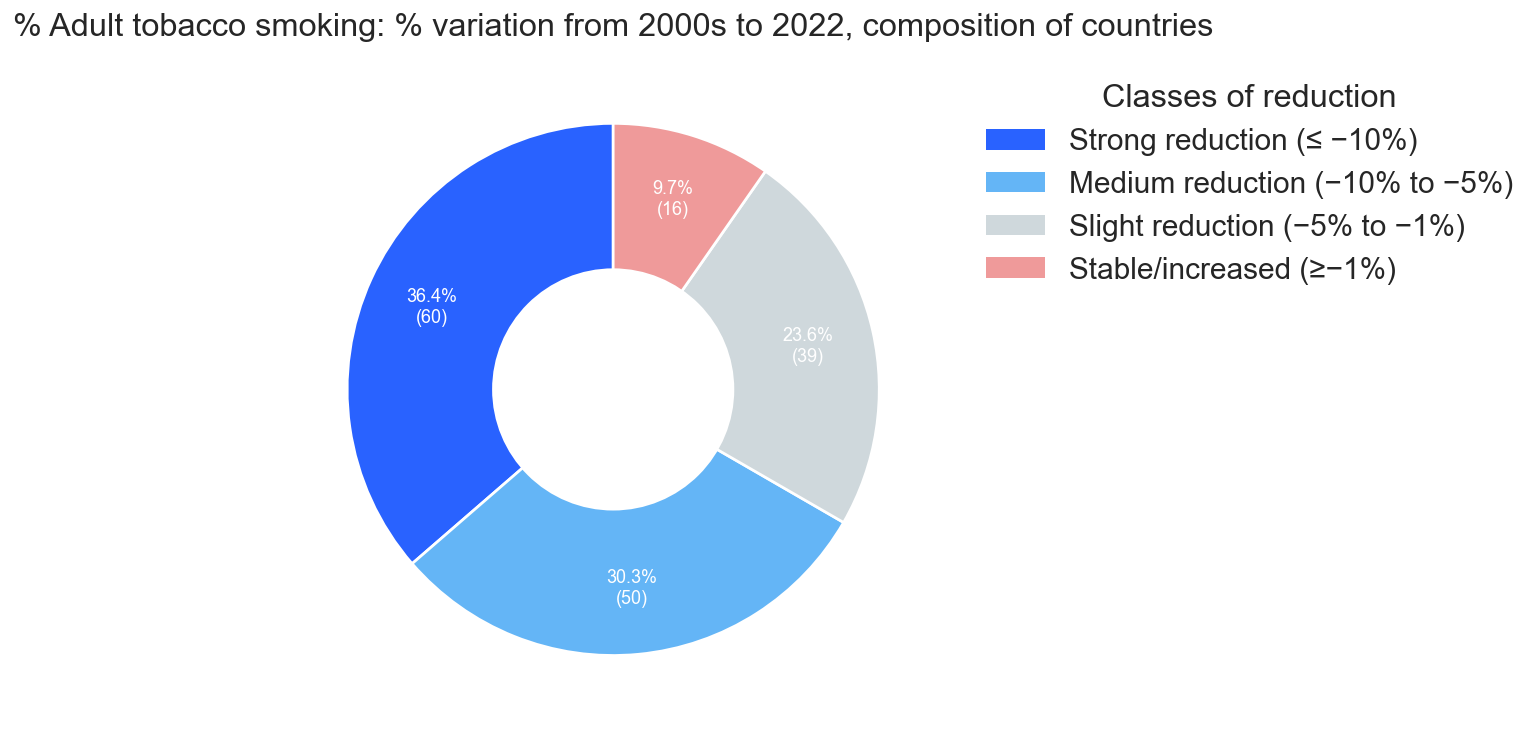

In [7]:
# === Donut Δ 2000→2022 (SOLO donut + legenda colori) — cella autonoma ===
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, os
from matplotlib.patches import Patch

# --- se df_f non esiste, prova a caricarlo dal file M (adatta il path se diverso)
if 'df_f' not in globals():
    # prova a trovare un csv M con stime di fumo (usa quello che hai usato per M1)
    import glob, re
    cand = (glob.glob("M/*.csv") + glob.glob("./M/*.csv"))
    # cerca un file con "smoking" e "estimate" (adatta se il tuo file si chiama diversamente)
    cand = [f for f in cand if re.search(r"smok|tobacco", f, flags=re.I)]
    if not cand:
        raise SystemExit("Non trovo un CSV di M da cui leggere df_f. Caricalo prima o aggiorna il path.")
    df_f = pd.read_csv(cand[0], encoding="utf-8-sig")

# --- helper per trovare colonne in modo robusto
def pick_col(cols, *aliases):
    m = {c.lower(): c for c in cols}
    for a in aliases:
        if a.lower() in m:
            return m[a.lower()]
    # match parziale
    for a in aliases:
        for c in cols:
            if a.lower() in c.lower():
                return c
    return None

iso_col  = pick_col(df_f.columns, "SpatialDimValueCode", "ISO3", "ISO")
loc_col  = pick_col(df_f.columns, "Location", "Country", "SpatialDim")
year_col = pick_col(df_f.columns, "Period", "Year", "TimeDim")

# Valore: prova in ordine Both→FactValueNumeric→NumericValue→Value; altrimenti il num. con più non-null
val_col  = pick_col(df_f.columns, "Both", "FactValueNumeric", "NumericValue", "Value")
if val_col is None:
    num_cols = [c for c in df_f.columns if pd.api.types.is_numeric_dtype(df_f[c])]
    drop_like = {year_col,}
    num_cols = [c for c in num_cols if c not in drop_like]
    if not num_cols:
        raise SystemExit("Non trovo una colonna numerica per il valore di prevalenza.")
    val_col = max(num_cols, key=lambda c: df_f[c].notna().sum())

# --- prepara i dati Paese (primo anno ~2000, ultimo ≤2022)
g = (df_f[[iso_col, loc_col, year_col, val_col]]
     .sort_values([iso_col, year_col])
     .drop_duplicates(subset=[iso_col, year_col], keep="last"))

per_country = (g.groupby([iso_col, loc_col], as_index=False)
                 .agg(y0=(val_col,"first"), y1=(val_col,"last")))
per_country["delta_pp"] = per_country["y1"] - per_country["y0"]

# classi Δ
bins   = [-np.inf, -10, -5, -1, np.inf]
labels = ["Strong reduction (≤ −10%)", "Medium reduction (−10% to −5%)",
          "Slight reduction (−5% to −1%)", "Stable/increased (≥−1%)"]
per_country["class"] = pd.cut(per_country["delta_pp"], bins=bins, labels=labels, right=True)

summary = (per_country["class"].value_counts()
           .reindex(labels).fillna(0).astype(int).reset_index())
summary.columns = ["Classe Δ", "N"]
summary["%"] = (100*summary["N"]/summary["N"].sum()).round(1)

# --- SOLO DONUT ---
sns.set_theme(context="talk")
fig, ax = plt.subplots(figsize=(10, 6), dpi=130)

colors = ["#2962ff", "#64b5f6", "#cfd8dc", "#ef9a9a"]  # blu → rosato
wedges, texts, autotexts = ax.pie(
    summary["N"], labels=summary["Classe Δ"], startangle=90,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p*summary['N'].sum()/100))})",
    pctdistance=0.75, colors=colors,
    textprops=dict(color="white", fontsize=10)
)

# buco centrale
centre_circle = plt.Circle((0, 0), 0.45, fc="white")
ax.add_artist(centre_circle)
ax.set_title("% Adult tobacco smoking: % variation from 2000s to 2022, composition of countries", pad=12)

# legenda colori (fuori a destra)
legend_handles = [Patch(facecolor=c, edgecolor="none", label=lab)
                  for c, lab in zip(colors, labels)]
ax.legend(handles=legend_handles, title="Classes of reduction",
          bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.tight_layout()
os.makedirs("M/outputs", exist_ok=True)
plt.savefig("M/outputs/monitor_donut_delta_global.png", bbox_inches="tight")
plt.show()


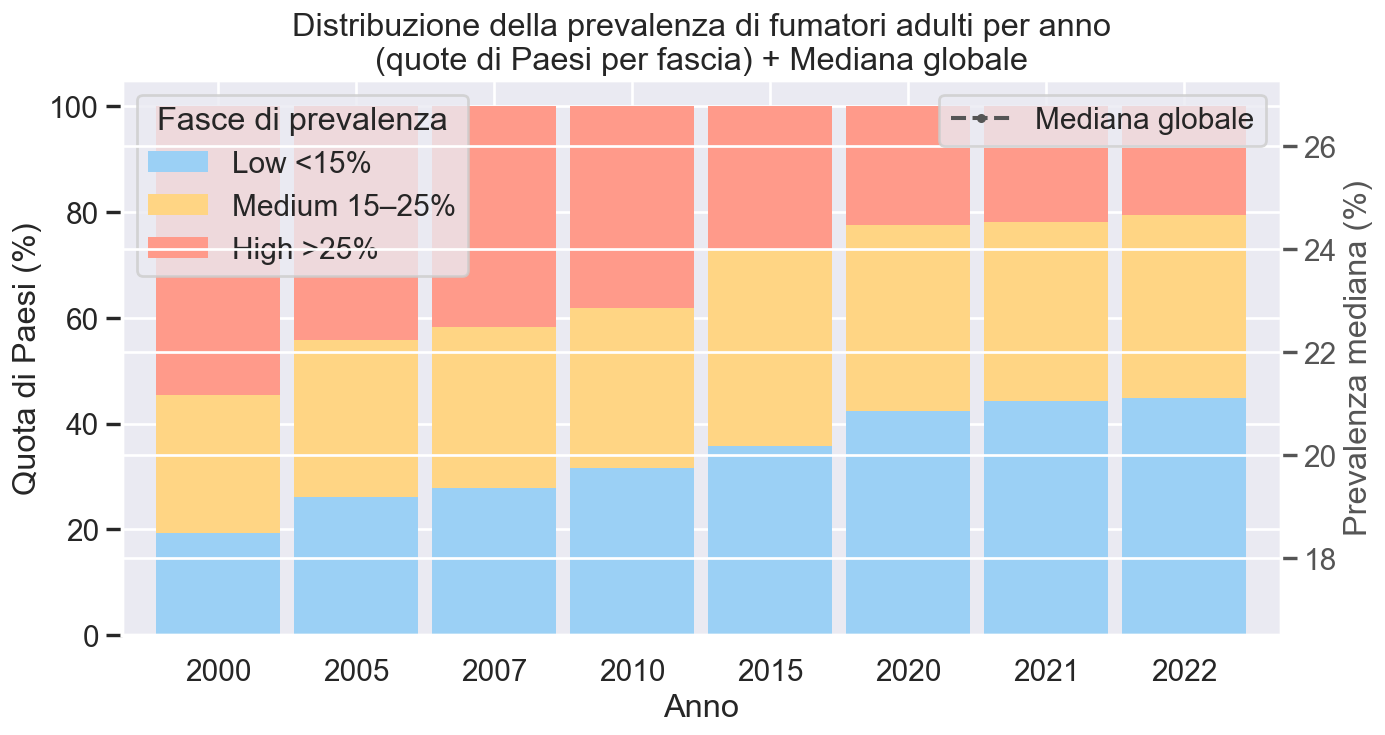

In [ ]:
# === ALTERNATIVA A: Barre impilate per fasce di prevalenza + linea della mediana globale ===
import pandas as pd, numpy as np, glob, re
import seaborn as sns, matplotlib.pyplot as plt

# --- carica & filtra (stesso file dei grafici M) ---
candidates = sorted(glob.glob("M/*age*standard*.*csv")) or sorted(glob.glob("./M/*age*standard*.*csv"))
df = pd.read_csv(candidates[0], encoding="utf-8-sig")
cols = {c.lower(): c for c in df.columns}
def pick(*names):
    for n in names:
        if n.lower() in cols: return cols[n.lower()]
    raise KeyError(names)

year_col = pick("Period","TimeDim","Year")
iso_col  = pick("SpatialDimValueCode","ISO3","ISO")
loc_col  = pick("Location","Country","SpatialDim")
sex_col  = cols.get("dim1") or cols.get("sex")
val_col  = cols.get("factvaluenumeric") or cols.get("value")
ind_col  = next((cols[k] for k in ["indicator","indicatorname","indicator_label","indicatorlabel","gho"] if k in cols), None)

df_f = df.copy()
if ind_col is not None and df_f[ind_col].dtype == object:
    m = df_f[ind_col].str.lower().str.contains(r"tobacco\s*smoking", regex=True)
    if m.any(): df_f = df_f[m]
if sex_col:
    df_f = df_f[df_f[sex_col].astype(str).str.contains(r"\bboth\b", flags=re.I, regex=True)]

df_f[val_col]  = pd.to_numeric(df_f[val_col], errors="coerce")
df_f[year_col] = pd.to_numeric(df_f[year_col], errors="coerce")
df_f = df_f[(df_f[year_col] >= 2000) & (df_f[year_col] <= 2022)]
df_f = df_f.dropna(subset=[val_col, year_col, iso_col])

# --- classi di prevalenza ---
bins  = [-np.inf, 15, 25, np.inf]
labels = ["Low <15%", "Medium 15–25%", "High >25%"]
df_f["band"] = pd.cut(df_f[val_col], bins=bins, labels=labels)

# quota Paesi per banda/anno (usa ultimi dati per Paese-anno se duplicati)
df_g = (df_f[[iso_col, year_col, "band", val_col]]
        .sort_values([iso_col, year_col])
        .drop_duplicates(subset=[iso_col, year_col], keep="last"))
counts = (df_g.groupby(year_col)['band']
          .value_counts(normalize=True)
          .mul(100)
          .rename('share')
          .reset_index())          # -> colonne: [Period, band, share]
shares = counts


# mediana globale per anno
# mediana globale per anno (fix definitivo)
med = df_g.groupby(year_col, as_index=False)[val_col].median().rename(columns={val_col: "median"})

# --- plot ---
sns.set_theme(context="talk")
fig, ax1 = plt.subplots(figsize=(11, 6), dpi=130)

# barre impilate
pivot = shares.pivot(index=year_col, columns="band", values="share").fillna(0)
pivot = pivot[[labels[0], labels[1], labels[2]]]  # ordine
pivot.plot(kind="bar", stacked=True, ax=ax1, width=0.9,
           color=["#9bd0f5", "#ffd584", "#ff9a8a"], edgecolor="none")

ax1.set_xlabel("Anno")
ax1.set_ylabel("Quota di Paesi (%)")
ax1.set_xticklabels(pivot.index.astype(int), rotation=0)

# linea della mediana (asse destro)
ax2 = ax1.twinx()
ax2.plot(med[year_col], med["median"], color="#555555", linestyle="--", marker="o", ms=4, label="Mediana globale")
ax2.set_ylabel("Prevalenza mediana (%)", color="#555555")
ax2.tick_params(axis='y', colors="#555555")

ax1.legend(title="Fasce di prevalenza", loc="upper left", ncols=1, frameon=True)
ax2.legend(loc="upper right", frameon=True)
plt.title("Distribuzione della prevalenza di fumatori adulti per anno\n(quote di Paesi per fascia) + Mediana globale")
plt.tight_layout()

import os; os.makedirs("M/outputs", exist_ok=True)
plt.savefig("M/outputs/monitor_stackbands_median.png", bbox_inches="tight")
plt.show()
